# CMPT 728/420 Deep Learning

## Assignment 3

### Assignment Goals:

* Implementing and improving RNN based language models.
* Implementing and applying a Recurrent Neural Network on text classification problem.


In this assignment, you will implement RNN-based language models and compare extracted word representation from different models. You will also compare two different training methods for sequential data: Truncated Backpropagation Through Time __(TBTT)__ and Backpropagation Through Time __(BTT)__.
Also, you will be asked to apply Vanilla RNN to capture word representations and solve a text classification problem.


### DataSets

You will use two datasets, an English Literature dataset for language model task (part 1 to 4) and the 20Newsgroups dataset for text classification (part 5).

### Requirements

1. **(30 points) Implement a RNN based language model.**

    Implement the RNN based language model described by [Mikolov et al.](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf), also called **Elman network**. The Elman network contains input, hidden and output layer and is trained by standard backpropagation (TBTT with $τ = 1$) using the cross-entropy loss.

      * The input vector $x(t)$ at time $t$ consists of the current word while using 1-of-N coding (thus its size is equal to the size of the vocabulary) $w(t)$ and a vector $s(t − 1)$ which represents output values in the hidden layer from the previous time step $t-1$.
      $$x(t) = w(t) + s(t-1)$$
      
      * The hidden layer is a fully connected tanh layer with size 500.
      $$s_j(t) = f(\sum_i x_i(t)u_{ji} )$$
      Here $u$ is the parameter matrix of hidden layer, $f$ is the tanh activation function.
      
      * The softmax output layer captures a valid probability distribution.
      $$y_k(t) = g(\sum_j s_j(t)v_{kj})$$
      Here $v$ is the parameter matrix of output layer, $g$ is the softmax function.
      
      * The model is trained with truncated backpropagation through time (TBTT) with $τ = 1$: the weights of the network are updated based on the error vector computed only for the current time step.
      
   Train the language model on the given English Literature dataset, report the model cross-entropy loss on the train set. Visualize the cross-entropy loss during training using a curve line. Your curve line should demonstrate that the loss value converges.
   
   Use nltk.word_tokenize to tokenize the documents. For initialization, $s(0)$ can be set to a vector of small values. Note that we are not interested in the *dynamic model* mentioned in the original paper.


2. **(20 points) Train the Elman network with BTT.**

    TBTT has less computational cost and memory needs in comparison with **backpropagation through time algorithm (BTT)**. These benefits come at the cost of losing long term dependencies ([reference](https://arxiv.org/abs/1705.08209)). TBTT is rarely used until now, we use BTT instead.

    Train your implemented Elman network with BTT, then compare the computational costs and performance of BTT and TBTT training.  For training the Elman-type RNN with BTT, one option is to perform mini-batch gradient descent with exactly one sentence per mini-batch. (Hints: The input  size will be (1, Sentence Length) ).

   * Split the document into sentences (you can use nltk.tokenize.sent_tokenize. The natural language toolkit (nltk) can be installed using the command 'pip install nltk').
   * For each sentence, perform one pass that computes the mean/sum loss for this sentence; then perform a gradient update for the whole sentence. (So the mini-batch size varies for the sentences with different lengths). You can truncate long sentences to fit the data in memory.
   * Report the model cross-entropy loss.Visualize the cross-entropy loss during training using a curve line. Your curve line should demonstrate that the loss value converges.

3. **(30 points) Improve your Elman network with GRU.**

    (a) Gated Recurrent Unit: It does not seem that simple recurrent neural networks can capture truly exploit context information with long dependencies, because of the problem of gradient vanishing and exploding. To solve this problem, gating mechanisms for recurrent neural networks were introduced. (15 points)

    Try to learn your last model (Elman + BTT) with the SimpleRnn unit replaced with a **Gated Recurrent Unit (GRU)**. Report the model cross-entropy loss.  Visualize the cross-entropy loss during training using a curve line. Your curve line should demonstrate that the loss value converges. Compare your results in terms of cross-entropy loss with two other approaches (part 1 and 2).

    (b) Text generation: Use each model to generate 10 synthetic sentences of 15 words each. Discuss the quality of the sentences generated - do they look like proper English? Do they match the training set? (15 points)
    
    Text generation from a given language model can be done using the following iterative process:
   - Set sequence = \[first_word\], chosen randomly.
   - Select a new word based on the sequence so far, add this word to the sequence, and repeat. At each iteration, select the word with maximum probability given the sequence so far. The trained language model outputs this probability.

4. **(20 points) Implement a text classification model.**

    We are aiming to learn an RNN model that predicts document categories given its content (text classification). For this task, we will use the 20Newsgroups dataset. The 20Newsgroupst contains messages from twenty newsgroups.  We selected four major categories (comp, politics, rec, and religion) comprising around 13k documents altogether. Your model should learn word representations to support the classification task. For solving this problem modify the **Elman network** architecture and simple RNN such that the last layer is a softmax layer with just 4 output neurons (one for each category).

    * Download the 20Newsgroups dataset, and use the below helper function data_loader() to read in the dataset.
    * Split the data into a training set (90%) and validation set (10%).
    * Implement your text classification model, and train the model on 20Newsgroups training set.
    * Report your accuracy results on the validation set. Try to achieve $\geq 80\%$ validation accuracy. (5 points)

### Submission Notes

Please use Jupyter Notebook. The notebook should include the final code, results and your answers. You should submit your Notebook in (.pdf or .html) and .ipynb format. (penalty 10 points)

To reduce the parameters, you can merge all words that occur less often than a threshold into a special rare token (\__unk__).

All the data directories in the code must be relative.

**Instructions：**

The university policy on academic dishonesty and plagiarism (cheating) will be taken very seriously in this course. Everything submitted should be your own writing or coding. You must not let other students copy your work. Spelling and grammar count.

Your assignments will be marked based on correctness, originality (the implementations and ideas are from yourself), and test performance.



## Your Implementation

In [1]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/CMPT420_HW3")
# !pwd

Mounted at /content/drive
/content/drive/MyDrive/CMPT420_HW3


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mikew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
part1_batch_size = 32
part2_batch_size = 1
part4_batch = 1
max_sent_len = 64
part1_epoch = 20
part2_epoch = 5
part3_epoch = 5
part4_epoch = 10
lr = 1e-4
hidden_size = 500
embedding_size = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = './data/English Literature.txt'
print(device)

cuda


### Helper function

In [3]:
# construct vocabulary
with open(data_path, 'r') as file:
    englishData = file.read()
tokenized_data = nltk.word_tokenize(englishData.lower())
vocabulary = set(tokenized_data)
word_to_idx = {word:i for i, word in enumerate(vocabulary)}
vocab_size = len(vocabulary)
tokenized_sentences = nltk.sent_tokenize(englishData.lower())
# print(vocab_size)
# print(len(tokenized_data))


In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Training Loss Curve')
    plt.show()


In [5]:
def initialize_parameters(model):
    for param in model.parameters():
        if param.requires_grad:
            nn.init.normal_(param, mean=0, std=0.1)

### 1. Implement a RNN based language model

In [8]:
class EnglishData(Dataset):
    def __init__(self, data, vocabulary):
        self.vocabulary = vocabulary
        self.data = data
        self.word_to_idx = {word:i for i, word in enumerate(self.vocabulary)}
        self.vocab_size = len(self.vocabulary)
    def __len__(self):
        return len(self.data)

    def one_hot_encoding(self, data_index):
        one_hot = torch.zeros(self.vocab_size)
        one_hot[data_index] = 1
        return one_hot
    def __getitem__(self, index):
        current_word = self.one_hot_encoding(self.word_to_idx[self.data[index]])
        if(index+1 >= len(self.data)):
            next_word = current_word
        else:
            next_word = self.one_hot_encoding(self.word_to_idx[self.data[index+1]])
        return current_word,next_word


# return one_hot encoding of currentword and nextword
part1_dataset = EnglishData(tokenized_data, vocabulary)
part1_dataloader = DataLoader(part1_dataset, batch_size = part1_batch_size, shuffle=True)




In [9]:

class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, s_prev):
        output, s = self.rnn(x,s_prev)
        output = self.fc(output)
        return output, s


In [10]:
def train(model, dataloader, optimizer, criterion, epochs, hidden_size):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        s_prev = torch.zeros(1,hidden_size).to(device)
        for (current,next) in tqdm(dataloader):
            current = current.to(device)
            next = next.to(device)
            output, s_prev = model(current, s_prev.detach())
            s_prev = s_prev.to(device)
            loss = criterion(output, next)
            total_loss += loss.item()
            optimizer.zero_grad()  # Reset gradients
            loss.backward(retain_graph=True)
            optimizer.step()
        avg_loss = total_loss/len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses, model

In [11]:
# define model
BaseModel = ElmanRNN(vocab_size,hidden_size,vocab_size).to(device)
initialize_parameters(BaseModel)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(BaseModel.parameters(), lr=lr)

In [12]:
# train
BaseModel.train()
# torch.autograd.set_detect_anomaly(True)
TBTT_losses, TBTTModel = train(BaseModel, dataloader=part1_dataloader,optimizer=optimizer, criterion=criterion, epochs=part1_epoch, hidden_size=hidden_size)
# plot_losses(losses)

100%|██████████| 7954/7954 [00:42<00:00, 188.03it/s]


Epoch 1/20, Loss: 6.5973


100%|██████████| 7954/7954 [00:40<00:00, 196.30it/s]


Epoch 2/20, Loss: 6.3104


100%|██████████| 7954/7954 [00:40<00:00, 195.77it/s]


Epoch 3/20, Loss: 6.1533


100%|██████████| 7954/7954 [00:40<00:00, 195.82it/s]


Epoch 4/20, Loss: 5.9896


100%|██████████| 7954/7954 [00:40<00:00, 196.57it/s]


Epoch 5/20, Loss: 5.9231


100%|██████████| 7954/7954 [00:41<00:00, 193.60it/s]


Epoch 6/20, Loss: 5.7651


100%|██████████| 7954/7954 [00:41<00:00, 193.36it/s]


Epoch 7/20, Loss: 5.6711


100%|██████████| 7954/7954 [00:40<00:00, 196.84it/s]


Epoch 8/20, Loss: 5.5932


100%|██████████| 7954/7954 [00:40<00:00, 195.87it/s]


Epoch 9/20, Loss: 5.5323


100%|██████████| 7954/7954 [00:40<00:00, 195.40it/s]


Epoch 10/20, Loss: 5.4800


100%|██████████| 7954/7954 [00:40<00:00, 194.62it/s]


Epoch 11/20, Loss: 5.4338


100%|██████████| 7954/7954 [00:40<00:00, 195.42it/s]


Epoch 12/20, Loss: 5.3907


100%|██████████| 7954/7954 [00:40<00:00, 195.62it/s]


Epoch 13/20, Loss: 5.3538


100%|██████████| 7954/7954 [00:40<00:00, 197.56it/s]


Epoch 14/20, Loss: 5.3201


100%|██████████| 7954/7954 [00:40<00:00, 195.77it/s]


Epoch 15/20, Loss: 5.2886


100%|██████████| 7954/7954 [00:40<00:00, 194.67it/s]


Epoch 16/20, Loss: 5.2592


100%|██████████| 7954/7954 [00:41<00:00, 193.82it/s]


Epoch 17/20, Loss: 5.2290


100%|██████████| 7954/7954 [00:41<00:00, 193.94it/s]


Epoch 18/20, Loss: 5.2030


100%|██████████| 7954/7954 [00:42<00:00, 187.57it/s]


Epoch 19/20, Loss: 5.1758


100%|██████████| 7954/7954 [00:44<00:00, 180.42it/s]

Epoch 20/20, Loss: 5.1528


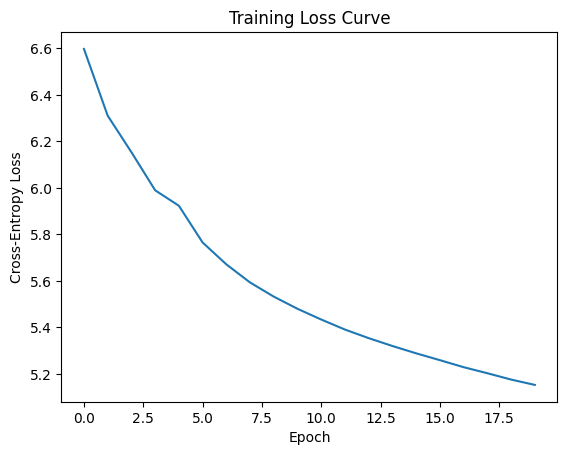

In [13]:
plot_losses(TBTT_losses)

### 2. Train the Elman network with BTT

In [14]:
class BTTData(Dataset):
    def __init__(self, data, vocabulary, max_sent_len):
        self.data = data
        self.vocabulary = vocabulary
        self.word_to_idx = {word:i for i, word in enumerate(self.vocabulary)}
        self.vocab_size = len(self.vocabulary)
        self.tokenized_sentence = [nltk.word_tokenize(sentence) for sentence in self.data]
        self.truncated_sentence = []
        for sentence in self.tokenized_sentence:
            if len(sentence) > max_sent_len:
                self.truncated_sentence.append(sentence[:max_sent_len])
            else:
                self.truncated_sentence.append(sentence)


    def __len__(self):
        return len(self.truncated_sentence)

    def one_hot_encoding(self, data_index):
        one_hot = [0] * self.vocab_size
        one_hot[data_index] = 1
        return one_hot
    def sentence_one_hot(self, sentence_idx):
        # TODO1: including padding, to fit in batch
        one_hot_sentence = []
        # for i in range(max_sent_len):
        #     if(i < len(self.truncated_sentence[sentence_idx])):
        #       one_hot_sentence.append(self.one_hot_encoding(self.word_to_idx[self.truncated_sentence[sentence_idx][i]]))
        #     else:
        #         one_hot_sentence.append([0] * self.vocab_size)
        # TODO2: without padding
        one_hot_sentence = []
        for token in self.truncated_sentence[sentence_idx]:
            one_hot_sentence.append(self.one_hot_encoding(self.word_to_idx[token]))

        return torch.tensor(one_hot_sentence, dtype=torch.float32)

    ## TODO: add mini_batch
    def __getitem__(self, index):
        return self.sentence_one_hot(index)

part2_dataset = BTTData(tokenized_sentences, vocabulary,max_sent_len)
part2_dataloader = DataLoader(part2_dataset, batch_size = part2_batch_size, shuffle=True)



In [15]:
#model
class BTT(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super(BTT, self).__init__()
        self.rnn = nn.RNN(vocab_size,hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden):
        output,hidden = self.rnn(input)
        output = self.fc(output)
        return output,hidden

In [16]:
def trainBTT(model, dataloader, optimizer, criterion,epochs=part2_epoch, hidden_size = hidden_size):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        hidden = torch.zeros(1,hidden_size).to(device)
        for sentence in tqdm(dataloader):
            sentence = sentence.to(device)
            target = sentence.clone()
            loss=0
            for i in range(sentence.size(1)):
                output, hidden = model(sentence[:, i,:], hidden.detach())
                # hidden = hidden.to(device)
                loss += criterion(output, target[:, i,:])
            total_loss += loss.item() / sentence.size(1)
            optimizer.zero_grad()  # Reset gradients
            loss.backward(retain_graph=True)
            optimizer.step()
        avg_loss = total_loss/len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses, model

In [17]:
# model definition

BTT_model=BTT(vocab_size,hidden_size,vocab_size)
BTT_model.to(device)
initialize_parameters(BTT_model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BTT_model.parameters(), lr=lr)

In [18]:
# train
BTT_model.train()
BTT_losses, BTTModel = trainBTT(BTT_model, part2_dataloader, optimizer, criterion)

100%|██████████| 12449/12449 [09:20<00:00, 22.21it/s]


Epoch 1/5, Loss: 2.4302


100%|██████████| 12449/12449 [09:15<00:00, 22.43it/s]


Epoch 2/5, Loss: 0.8139


100%|██████████| 12449/12449 [09:12<00:00, 22.52it/s]


Epoch 3/5, Loss: 0.5306


100%|██████████| 12449/12449 [09:22<00:00, 22.15it/s]


Epoch 4/5, Loss: 0.4013


100%|██████████| 12449/12449 [09:23<00:00, 22.11it/s]

Epoch 5/5, Loss: 0.3250


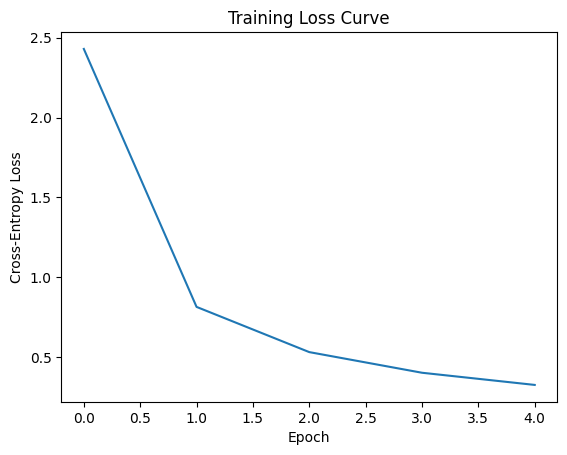

In [19]:
# plot losses
plot_losses(BTT_losses)

### 3. Improve your Elman network with GRU

#### define GRU model

In [20]:
# model
class GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.gru = nn.GRU(vocab_size,hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden):
        output,hidden = self.gru(input)
        output = self.fc(output)
        return output,hidden

In [21]:
# train function

def trainGRU(model, dataloader, optimizer, criterion, epochs=part3_epoch, hidden_size = hidden_size):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        hidden = torch.zeros(1,hidden_size).to(device)
        for sentence in tqdm(dataloader):
            sentence = sentence.to(device)
            target = sentence.clone()
            loss=0
            for i in range(sentence.size(1)):
                output, hidden = model(sentence[:, i,:], hidden.detach())
                # hidden = hidden.to(device)
                loss += criterion(output, target[:, i,:])
            total_loss += loss.item() / sentence.size(1)
            optimizer.zero_grad()  # Reset gradients
            loss.backward(retain_graph=True)
            optimizer.step()
        avg_loss = total_loss/len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses, model

In [22]:
# model definition

GRU_model=GRU(vocab_size,hidden_size,vocab_size)
GRU_model.to(device)
initialize_parameters(GRU_model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=lr)

In [23]:
# train model
losses, GRUModel = trainGRU(GRU_model, part2_dataloader, optimizer, criterion)

100%|██████████| 12449/12449 [09:51<00:00, 21.03it/s]


Epoch 1/5, Loss: 2.7909


100%|██████████| 12449/12449 [09:48<00:00, 21.14it/s]


Epoch 2/5, Loss: 0.8426


100%|██████████| 12449/12449 [09:38<00:00, 21.51it/s]


Epoch 3/5, Loss: 0.5185


100%|██████████| 12449/12449 [09:43<00:00, 21.33it/s]


Epoch 4/5, Loss: 0.3823


100%|██████████| 12449/12449 [09:44<00:00, 21.29it/s]

Epoch 5/5, Loss: 0.3058


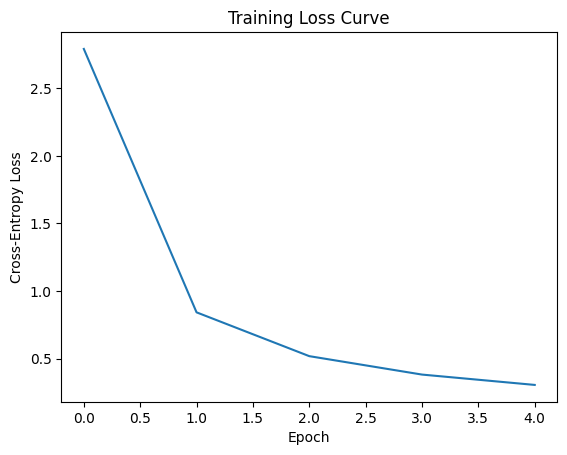

In [24]:
# plot losses
plot_losses(losses)

#### Model comparison

In [25]:
# hyper-parameters:
num_sentences = 10
sentence_length = 15

In [26]:
def one_hot_encoding(idx, vocab_size):
    one_hot = [0] * vocab_size
    one_hot[idx] = 1
    return one_hot

In [27]:
# Model comparison:

def generate_sentence(model, idx, vocab, hidden_size, max_length ):
    model.eval()
    vocab_size = len(vocab)
    one_hot_word = one_hot_encoding(idx, vocab_size)
    # print(one_hot_word)
    one_hot_sentence = []
    one_hot_sentence.append(one_hot_word)
    sentence = []
    sentence.append(idx)
    with torch.no_grad():
        current_sentence = torch.tensor(one_hot_sentence, dtype=torch.float32).to(device)
        hidden = torch.zeros(1,hidden_size ).to(device)
        model.to(device)
        for i in range(max_length - 1):
            # print(i)
            output, hidden = model(current_sentence, hidden)
            output = F.softmax(output, dim=1)
            # print(output.shape)
            next_word_index = torch.argmax(output[-1:], dim=1).item()
            sentence.append(next_word_index)
            one_hot_sentence.append(one_hot_encoding(next_word_index, vocab_size))
            current_sentence = torch.tensor(one_hot_sentence, dtype=torch.float32)
            # TODO: put current_word and hidden to device
            current_sentence = current_sentence.to(device)
            hidden = hidden.to(device)

    # Convert tokenized sentence back to words using vocabulary
    vocab_list = list(vocab)
    sentence_words = [vocab_list[word_index] for word_index in sentence]

    return sentence_words


In [28]:
def combine_sentence(sentence):
    combined_sentence = ""
    for word in sentence:
        combined_sentence += word + " "
    return combined_sentence

In [29]:
base_sentences = []
btt_sentences = []
gru_sentences = []
for i in range(num_sentences):
    rand_int = random.randint(0, vocab_size-1)
    base_sentences.append(combine_sentence(generate_sentence(TBTTModel, rand_int, vocabulary, hidden_size, max_length = sentence_length)))
    btt_sentences.append(combine_sentence(generate_sentence(BTTModel, rand_int, vocabulary, hidden_size, max_length = sentence_length)))
    gru_sentences.append(combine_sentence(generate_sentence(GRUModel, rand_int, vocabulary, hidden_size, max_length = sentence_length)))

In [30]:
print("\nsentences with model_part1: \n")
for i in range(num_sentences):
    print(base_sentences[i])
print("\nsentences with model_part2: \n")
for i in range(num_sentences):
    print(btt_sentences[i])
print("\nsentences with model_part3: \n")
for i in range(num_sentences):
    print(gru_sentences[i])


sentences with model_part1: 

deserves it . i 'll be so , and i have been a little . 
squared me speak to the king edward iv : i have been a little , 
hallowed and what you have been a little , and i have i 'll be 
unsatiate vincentio : i 'll be so , and i have been a little . 
team of his father , and i have been a little . king richard iii 
treasonable that he shall i have been a little , and i have i 'll 
adage pray you have been in the king edward iv : i have been a 
big-swoln heart , and let him . duke vincentio : i have been a little 
greyhounds are the two in the king edward iv : i have been a little 
tired ; and you shall i 'll be so , and i have been a 

sentences with model_part2: 

deserves deserves deserves deserves deserves fortunes rosaline turns private denied for't ignorance pace nice rejoice 
squared squared squared , , , , , , , , , , , , 
hallowed hallowed angel angel angel fare apparent watch veins post-haste unbuild sue heavens ducat proof 
unsatiate unsatiate uns

#### Conclusion: 

The first model which is trained with standard backword looks like proper English the most, while models for part 2 and 3 have bad quality. 

### 4. Implement a text classification model

In [6]:
data_path = "./data/20news_subsampled"

In [7]:
"""This code is used to read all news and their labels"""
import os
import glob

def to_categories(name, cat=["politics","rec","comp","religion"]):
    for i in range(len(cat)):
        if str.find(name,cat[i])>-1:
            return(i)
    print("Unexpected folder: " + name) # print the folder name which does not include expected categories
    return("wth")

def data_loader(images_dir):
    categories = os.listdir(data_path)
    news = [] # news content
    groups = [] # category which it belong to

    for cat in categories:
        print("Category:"+cat)
        for the_new_path in glob.glob(data_path + '/' + cat + '/*'):
            news.append(open(the_new_path,encoding = "ISO-8859-1", mode ='r').read())
            groups.append(cat)

    return news, list(map(to_categories, groups))



#data_path = "20Newsgroups_subsampled"
data_path = "./data/20news_subsampled"
news, groups = data_loader(data_path)

Category:rec.autos
Category:talk.politics.mideast


In [8]:
# construct vocabulary:
vocabulary = []
documents = []
for new in news:
    words = nltk.word_tokenize(new)
    documents.append(words)
    vocabulary += words
vocabulary_part4 = set(vocabulary)
word_to_idx_part4 = {word:i for i, word in enumerate(vocabulary_part4)}
vocab_size_part4 = len(vocabulary_part4)

In [9]:
class TextClassData(Dataset):
    def __init__(self, data_news, category, vocabulary):
        self.data = data_news
        self.vocabulary = vocabulary
        self.category = category
        # print(type(self.category))
        self.word_to_idx = {word:i for i, word in enumerate(self.vocabulary)}
        self.vocab_size = len(self.vocabulary)
        # self.truncated_sentences = []
        # for new in self.data:
        #     # print(new)
        #     sentences = []
        #     for sentence in new:
        #         # print(sentence)
        #         tokenized_sentence = nltk.word_tokenize(sentence)
        #         # print(tokenized_sentence)
        #         if len(tokenized_sentence) > max_sent_len:
        #             sentences.append(tokenized_sentence[:max_sent_len])
        #         else:
        #             sentences.append(tokenized_sentence)
        #     self.truncated_sentences.append(sentences)



    def __len__(self):
        return len(self.data)

    def one_hot_encoding(self, data_index):
        one_hot = [0] * self.vocab_size
        one_hot[data_index] = 1
        return one_hot
    def sentence_one_hot(self, new_idx):
        # TODO1: including padding, to fit in batch
        one_hot_sentences = []
        # for i in range(max_sent_len):
        #     if(i < len(self.truncated_sentence[sentence_idx])):
        #       one_hot_sentence.append(self.one_hot_encoding(self.word_to_idx[self.truncated_sentence[sentence_idx][i]]))
        #     else:
        #         one_hot_sentence.append([0] * self.vocab_size)
        # TODO2: without padding
        for token in self.data[new_idx]:
            one_hot_sentences.append(self.one_hot_encoding(self.word_to_idx[token]))

        return torch.tensor(one_hot_sentences, dtype=torch.float32)
        # return one_hot_sentences

    ## TODO: add mini_batch
    def __getitem__(self, index):
        # print(self.category[index])
        category = self.category[index]
        target = torch.zeros(4)
        target[category] = 1
        return self.sentence_one_hot(index), target
        # return self.category[index]

# print(type(groups))
part4_dataset = TextClassData(documents, groups,vocabulary_part4)

In [10]:
# split data
total_size=len(part4_dataset)
train_size=int(total_size*0.9)
val_size=total_size-train_size
train_set, val_set = random_split(part4_dataset, [train_size, val_size])
data_loader4_train = DataLoader(train_set, shuffle=True)
data_loader4_val = DataLoader(val_set, shuffle=True)

In [11]:
# model
class TextClassModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super(TextClassModel, self).__init__()
        self.gru = nn.GRU(vocab_size,hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden):
        output,hidden = self.gru(input)
        output = self.fc(output)
        return output,hidden

In [16]:
def trainTextClass(model, dataloader, optimizer, criterion, epochs=1, hidden_size = hidden_size):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        hidden = torch.zeros(1,hidden_size).to(device)
        for (new, target) in tqdm(dataloader):
            new = new.to(device)
            target = target.to(device)
            output,_ = model(new, hidden)
            output = output[:,-1,:].squeeze(1)
            # print(output.shape, target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()
            optimizer.zero_grad()  # Reset gradients
            loss.backward(retain_graph=True)
            optimizer.step()
        avg_loss = total_loss/len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses, model

In [17]:
TextClass_Model=TextClassModel(vocab_size_part4,hidden_size,4).to(device)
initialize_parameters(TextClass_Model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(TextClass_Model.parameters(), lr=lr)

In [18]:
TextClass_Model.train()
losses,_ = trainTextClass(TextClass_Model, data_loader4_train, optimizer, criterion)

100%|██████████| 1386/1386 [36:56<00:00,  1.60s/it]  

Epoch 1/1, Loss: 0.6493
